## Análisis de Clasificación de información extraida de imágenes de masas cancerígenas mamarias

La información de análisis corresponde a características que se extrajeron de imágenes digitalizadas de masas cancerígenas mamarias. La información se refiere a los núcleos de la células visibles en las imágenes. En total la base de análisis contiene 569 registros y 12 variables, que son:

1. Identificación: ID number
2. Diagnóstico: Diagnosis (M = malignant, B = benign)
3. Radio: Radius (mean of distances from center to points on the perimeter)
4. Textura: Texture (standard deviation of gray-scale values)
5. Perimetro: Perimeter
6. Área: Area
7. Suavidad: Smoothness (local variation in radius lengths)
8. Compactación: Compactness (perimeter^2 / area - 1.0)
9. Concavidad: Concavity (severity of concave portions of the contour)
10. Puntos de Concavidad: Concave points (number of concave portions of the contour)
11. Simetría: Symmetry
12. Dimensión Fractal:  Fractal dimension ("coastline approximation" - 1)

Sobre cada una se cálculo la media, error estandar y el "peor" (promedio de los tres mayores valores) generando 30 variables de análisis. Las medidas tienen un formato con hasta 4 cifras decimales. Los datos no contienen valores faltantes. 

Finalmente la proporción de masas malignas sobre benignas es 0.57, esto es de 569 masas análizadas 212 son malignas.

## Pasos de análisis
1. Importar paquetes de trabajo
2. Lectura de datos (disco local)
3. Análisis descriptivo de los datos y selección de variables
4. Separar X (Variables explicativas) de Y (Variable respuesta)
5. Normalizar datos
6. División de datos en Trainning y Test
7. Crear modelo con API
8. Calibrar epochs y data de validación
9. Graficar historia de ajuste y validación
10. Graficar matriz de confusión y procentaje de precisión obtenido

#### Paso 1: Importar paquetes de trabajo

In [1]:
!pip install tensorflow
!pip install keras
!pip install pydot
!pip install graphviz
!pip install pydotplus
import numpy as np
import pandas as pd
import seaborn as sb

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
print("Versión de Tensorflow:", tf.__version__)

Versión de Tensorflow: 2.4.1


#### Paso 2: Lectura de datos (disco local)

In [2]:
dfbm=pd.read_csv('~/Desktop/Diplomado UNAL/BreastCancer/data.csv', delimiter=",", low_memory=False, index_col=False,keep_date_col=True)
print("Total obs: " + "{:,}" .format(len(dfbm))+ " records")
print("Dimension of df:", dfbm.shape)
dfbm.head()

Total obs: 569 records
Dimension of df: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### Paso 3: Análisis descriptivo de los datos y selección de variables

In [3]:
dfbm.describe(include='all')

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.037183e+07,NaN,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,NaN,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,NaN,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,NaN,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,NaN,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,NaN,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN


#### Paso 4: Separar X (Variables explicativas) de Y (Variable respuesta)

In [4]:
#X=dfbm[['radius_mean','texture_mean','perimeter_mean','smoothness_mean','compactness_mean','concavity_mean',
#       'concave points_mean','symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se',
#       'smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se',
#       'radius_worst','texture_worst','perimeter_worst','smoothness_worst','compactness_worst','concavity_worst',
#       'concave points_worst','symmetry_worst','fractal_dimension_worst','area_mean','area_worst','area_se']]

X=dfbm[['texture_mean','perimeter_mean','compactness_mean','concavity_mean',
       'concave points_mean','symmetry_mean','fractal_dimension_mean','perimeter_se',
       'compactness_se','concavity_se','symmetry_se','fractal_dimension_se',
       'radius_worst','perimeter_worst','smoothness_worst','compactness_worst','concavity_worst',
       'concave points_worst','symmetry_worst','fractal_dimension_worst','area_mean','area_worst','area_se']]

Target=dfbm['diagnosis']
Target_Dummy= pd.get_dummies(Target, prefix='Diagnosis')
Y=Target_Dummy
print(Y)

     Diagnosis_B  Diagnosis_M
0              0            1
1              0            1
2              0            1
3              0            1
4              0            1
..           ...          ...
564            0            1
565            0            1
566            0            1
567            0            1
568            1            0

[569 rows x 2 columns]


#### Paso 5: Normalizar datos

In [5]:
scaler = StandardScaler()
scaler.fit(X)
print (scaler.mean_)
X = scaler.transform(X)

[1.92896485e+01 9.19690334e+01 1.04340984e-01 8.87993158e-02
 4.89191459e-02 1.81161863e-01 6.27976098e-02 2.86605923e+00
 2.54781388e-02 3.18937163e-02 2.05422988e-02 3.79490387e-03
 1.62691898e+01 1.07261213e+02 1.32368594e-01 2.54265044e-01
 2.72188483e-01 1.14606223e-01 2.90075571e-01 8.39458172e-02
 6.54889104e+02 8.80583128e+02 4.03370791e+01]


#### Paso 6: División de datos en Trainning y Test

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=0)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train.shape

(398, 23)

In [8]:
X_test.shape

(171, 23)

In [9]:
Y_test.shape

(171, 2)

In [10]:
Y_test.describe()

,Diagnosis_B,Diagnosis_M
count,171.000000,171.000000
mean,0.631579,0.368421
std,0.483793,0.483793
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


#### Paso 7: Crear modelo con API

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_inicial (InputLayer)    [(None, 23)]              0         
_________________________________________________________________
activation (Activation)      (None, 23)                0         
_________________________________________________________________
Primera_capa_oculta (Dense)  (None, 8)                 192       
_________________________________________________________________
Segunda_capa_oculta (Dense)  (None, 16)                144       
_________________________________________________________________
Capa_de_salida (Dense)       (None, 2)                 34        
Total params: 370
Trainable params: 370
Non-trainable params: 0
_________________________________________________________________


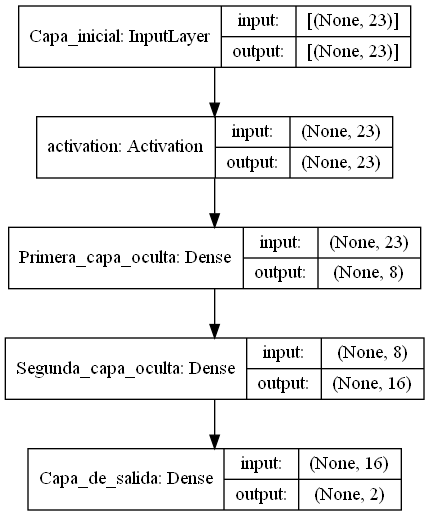

In [11]:
inputs=Input(shape=(23,), name='Capa_inicial')
model_bm=Activation('softplus')(inputs)
model_bm=Dense(8, activation='relu', name='Primera_capa_oculta')(model_bm)
model_bm=Dense(16, activation='relu', name='Segunda_capa_oculta')(model_bm)
outputs=Dense(2, activation='softmax',name='Capa_de_salida')(model_bm)

model_bm=Model(inputs=inputs, outputs=outputs)

model_bm.summary()
plot_model(model_bm, to_file='../BreastCancer/model_bm.png', show_shapes=True)

#### Paso 8: Calibrar epochs y data de validación

In [12]:
model_bm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

class Printline(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('-', end='')
epochs = 100

history = model_bm.fit(X_train, Y_train,
                    batch_size= 10,
                    epochs= epochs,
                    validation_split=0.15, verbose=0,
                    callbacks=[Printline()])


----------------------------------------------------------------------------------------------------

#### Paso 9: Grafica historia de ajuste y validación

In [13]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,0.059620,0.973373,0.056943,0.983333,95
96,0.051176,0.982249,0.054212,0.983333,96
97,0.053072,0.982249,0.055627,0.983333,97
98,0.053062,0.982249,0.054026,0.983333,98
99,0.052695,0.979290,0.110513,0.950000,99


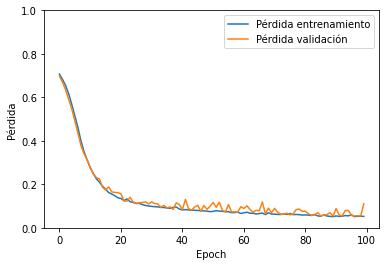

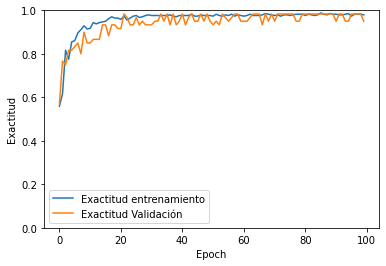

In [14]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Pérdida')
  plt.plot(hist['epoch'], hist['loss'],
           label='Pérdida entrenamiento')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Pérdida validación')
  plt.ylim([0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Exactitud')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Exactitud entrenamiento')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Exactitud Validación')
  plt.ylim([0,1])
  plt.legend()
  plt.show()
plot_history(history)

#### Paso 10: Graficar matriz de confusión y procentaje de precisión obtenido

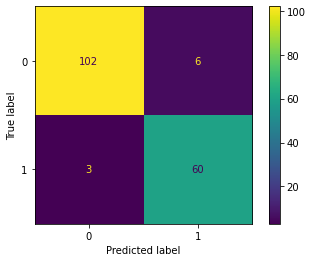

In [15]:
y_pred = model_bm.predict(X_test)
y_pred_c = np.argmax(y_pred, axis=1)
cm = confusion_matrix(Y_test['Diagnosis_M'], y_pred_c)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [16]:
print("Our accuracy is {}%".format(((cm[0][0] + cm[1][1])/Y_test.shape[0])*100))

Our accuracy is 94.73684210526315%
